# LoRA の実装

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/py-img-gen/python-image-generation/blob/main/notebooks/5-4-1_lora.ipynb)

## 準備

In [ ]:
!pip install -qq py-img-gen[lora,quantization]

In [1]:
model_id = "stable-diffusion-v1-5/stable-diffusion-v1-5"

In [2]:
import pathlib

current_dir = pathlib.Path.cwd()
project_dir = current_dir / "data" / "lora"
project_dir.mkdir(exist_ok=True, parents=True)
print(f"Created a directory: {project_dir}")

Created a directory: /root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/lora


In [3]:
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    UNet2DConditionModel,
)
from transformers import CLIPTextModel, CLIPTokenizer

text_encoder = CLIPTextModel.from_pretrained(
    model_id,
    subfolder="text_encoder",
)
tokenizer = CLIPTokenizer.from_pretrained(
    model_id,
    subfolder="tokenizer",
)
vae = AutoencoderKL.from_pretrained(
    model_id,
    subfolder="vae",
)
unet = UNet2DConditionModel.from_pretrained(
    model_id,
    subfolder="unet",
)
noise_scheduler = DDPMScheduler.from_pretrained(
    model_id,
    subfolder="scheduler",
)

In [4]:
from dataclasses import dataclass
from typing import Optional


@dataclass
class DatasetConfig(object):
    name: str = "py-img-gen/ukiyo-e-face-blip2-captions"
    config_name: Optional[str] = None
    cache_dir: Optional[str] = None
    image_column: str = "image"
    caption_column: str = "caption"


dataset_config = DatasetConfig()

In [5]:
import datasets as ds

dataset = ds.load_dataset(
    path=dataset_config.name,
    name=dataset_config.config_name,
    cache_dir=dataset_config.cache_dir,
)
assert isinstance(dataset, ds.DatasetDict)
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'caption'],
        num_rows: 5209
    })
})

In [6]:
from dataclasses import dataclass


@dataclass
class Hyperparameter(object):
    seed: int = 19950815
    num_train_epochs: int = 100
    learning_rate: float = 1e-4
    is_scale_lr: bool = False
    lr_scheduler: str = "constant"
    lr_warmup_steps: int = 0
    gradient_accumulation_steps: int = 1
    gradient_checkpointing: bool = True
    max_grad_norm: float = 1.0
    mixed_precision: str = "fp16"
    lora_rank: int = 4
    image_size: int = 512
    center_crop: bool = False
    random_flip: bool = False
    train_batch_size: int = 16
    save_steps: int = 500
    output_dir_path: pathlib.Path = project_dir

    # `bitsandbytes` による 8-bit 最適化を利用する場合は `True` にしてください
    use_8bit_adam: bool = True


hparams = Hyperparameter()
hparams

Hyperparameter(seed=19950815, num_train_epochs=100, learning_rate=0.0001, is_scale_lr=False, lr_scheduler='constant', lr_warmup_steps=0, gradient_accumulation_steps=1, gradient_checkpointing=True, max_grad_norm=1.0, mixed_precision='fp16', lora_rank=4, image_size=512, center_crop=False, random_flip=False, train_batch_size=16, save_steps=500, output_dir_path=PosixPath('/root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/lora'), use_8bit_adam=True)

In [7]:
def tokenize_captions(examples, is_train=True):
    # Preprocessing the datasets.
    # We need to tokenize input captions and transform the images.

    captions = []
    for caption in examples[dataset_config.caption_column]:
        if isinstance(caption, str):
            captions.append(caption)
        elif isinstance(caption, (list, np.ndarray)):
            # take a random caption if there are multiple
            captions.append(
                random.choice(caption)
                if is_train
                else caption[0]
            )
        else:
            raise ValueError(
                f"Caption column `{dataset_config.caption_column}` "
                "should contain either strings or lists of strings."
            )
    inputs = tokenizer(
        captions,
        max_length=tokenizer.model_max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )
    return inputs.input_ids

In [8]:
from torchvision import transforms

# Preprocessing the datasets.
train_transforms = transforms.Compose(
    [
        transforms.Resize(
            hparams.image_size,
            interpolation=transforms.InterpolationMode.BILINEAR,
        ),
        transforms.CenterCrop(hparams.image_size)
        if hparams.center_crop
        else transforms.RandomCrop(hparams.image_size),
        transforms.RandomHorizontalFlip()
        if hparams.random_flip
        else transforms.Lambda(lambda x: x),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [9]:
def preprocess_train(examples):
    images = [
        image.convert("RGB")
        for image in examples[dataset_config.image_column]
    ]
    examples["pixel_values"] = [
        train_transforms(image) for image in images
    ]
    examples["input_ids"] = tokenize_captions(examples)
    return examples


train_dataset = dataset["train"].with_transform(
    preprocess_train
)

In [10]:
import torch


def collate_fn(examples):
    pixel_values = torch.stack(
        [example["pixel_values"] for example in examples]
    )
    pixel_values = pixel_values.to(
        memory_format=torch.contiguous_format
    ).float()
    input_ids = torch.stack(
        [example["input_ids"] for example in examples]
    )
    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
    }

In [11]:
unet.requires_grad_(False)
vae.requires_grad_(False)
text_encoder.requires_grad_(False)

if hparams.gradient_checkpointing:
    unet.enable_gradient_checkpointing()

In [12]:
import math
from typing import Dict

from accelerate import Accelerator
from accelerate.utils import set_seed
from diffusers import StableDiffusionPipeline
from diffusers.optimization import get_scheduler
from diffusers.training_utils import cast_training_params
from diffusers.utils import convert_state_dict_to_diffusers
from diffusers.utils.torch_utils import is_compiled_module
from peft import LoraConfig
from peft.utils import get_peft_model_state_dict
from torch.utils.data import DataLoader
from tqdm.auto import tqdm


def training_function(
    text_encoder: CLIPTextModel,
    vae: AutoencoderKL,
    unet: UNet2DConditionModel,
):
    # 学習の再現性を確保するために乱数の seed を固定
    set_seed(hparams.seed)

    # 学習を効率化する Accelerator の設定
    accelerator = Accelerator(
        gradient_accumulation_steps=hparams.gradient_accumulation_steps,
        mixed_precision=hparams.mixed_precision,
    )
    print(accelerator.state)

    # For mixed precision training we cast all non-trainable weights (vae, non-lora text_encoder and non-lora unet) to half-precision
    # as these weights are only used for inference, keeping weights in full precision is not required.
    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16
    else:
        raise ValueError(
            f"Invalid dtype: {accelerator.mixed_precision}"
        )

    # Freeze the unet parameters before adding adapters
    for param in unet.parameters():
        param.requires_grad_(False)

    # Move unet, vae and text_encoder to device and cast to weight_dtype
    unet.to(accelerator.device, dtype=weight_dtype)
    vae.to(accelerator.device, dtype=weight_dtype)
    text_encoder.to(accelerator.device, dtype=weight_dtype)

    # Add adapter and make sure the trainable params are in float32.
    unet_lora_config = LoraConfig(
        r=hparams.lora_rank,
        lora_alpha=hparams.lora_rank,
        init_lora_weights="gaussian",
        target_modules=["to_k", "to_q", "to_v", "to_out.0"],
    )
    unet.add_adapter(unet_lora_config)
    if hparams.mixed_precision == "fp16":
        # only upcast trainable parameters (LoRA) into fp32
        cast_training_params(unet, dtype=torch.float32)

    # Filter out parameters for LoRA layers
    lora_layers = list(
        filter(lambda p: p.requires_grad, unet.parameters())
    )

    # 学習率をハイパーパラメータを考慮してスケーリングする
    learning_rate = (
        (
            hparams.learning_rate
            * hparams.gradient_accumulation_steps
            * hparams.train_batch_size
            * accelerator.num_processes
        )
        if hparams.is_scale_lr
        else hparams.learning_rate
    )

    # Colab の T5 GPU のような、16 GB 以下の GPU RAM の場合は
    # fine-tuning 時のメモリ使用量を減らすために 8-bit の Adam optimizer を使用
    if hparams.use_8bit_adam:
        import bitsandbytes as bnb

        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW

    optimizer = optimizer_class(
        lora_layers,
        lr=learning_rate,
    )

    train_data_loader = DataLoader(
        train_dataset,
        batch_size=hparams.train_batch_size,
        collate_fn=collate_fn,
        shuffle=True,
        num_workers=4,
    )

    # Scheduler and math around the number of training steps.
    # Check the PR https://github.com/huggingface/diffusers/pull/8312 for detailed explanation.
    num_warmup_steps_for_scheduler = (
        hparams.lr_warmup_steps * accelerator.num_processes
    )
    len_train_dataloader_after_sharding = math.ceil(
        len(train_data_loader) / accelerator.num_processes
    )
    num_update_steps_per_epoch = math.ceil(
        len_train_dataloader_after_sharding
        / hparams.gradient_accumulation_steps
    )
    num_training_steps_for_scheduler = (
        hparams.num_train_epochs
        * num_update_steps_per_epoch
        * accelerator.num_processes
    )

    lr_scheduler = get_scheduler(
        hparams.lr_scheduler,
        optimizer=optimizer,
        num_warmup_steps=num_warmup_steps_for_scheduler,
        num_training_steps=num_training_steps_for_scheduler,
    )

    # Prepare everything with our `accelerator`.
    unet, optimizer, train_data_loader, lr_scheduler = (
        accelerator.prepare(
            unet, optimizer, train_data_loader, lr_scheduler
        )
    )

    max_train_steps = (
        hparams.num_train_epochs
        * num_update_steps_per_epoch
    )
    hparams.num_train_epochs = math.ceil(
        max_train_steps / num_update_steps_per_epoch
    )

    # Train!
    total_batch_size = (
        hparams.train_batch_size
        * accelerator.num_processes
        * hparams.gradient_accumulation_steps
    )

    print("***** Running training *****")
    print(f"  Num examples = {len(train_dataset)}")
    print(f"  Num Epochs = {hparams.num_train_epochs}")
    print(
        f"  Instantaneous batch size per device = {hparams.train_batch_size}"
    )
    print(
        f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}"
    )
    print(
        f"  Gradient Accumulation steps = {hparams.gradient_accumulation_steps}"
    )
    print(f"  Total optimization steps = {max_train_steps}")

    def unwrap_model(model):
        model = accelerator.unwrap_model(model)
        model = (
            model._orig_mod
            if is_compiled_module(model)
            else model
        )
        return model

    progress_bar = tqdm(
        range(0, max_train_steps),
        disable=not accelerator.is_local_main_process,
        desc="Steps",
    )

    global_step = 0
    train_data_iter = iter(train_data_loader)

    while global_step != max_train_steps:
        try:
            batch = next(train_data_iter)
        except StopIteration:
            train_data_iter = iter(train_data_loader)
            batch = next(train_data_iter)

        with accelerator.accumulate(unet):
            loss = train_step(
                batch=batch,
                text_encoder=text_encoder,
                vae=vae,
                unet=unet,
                noise_scheduler=noise_scheduler,
                lora_layers=lora_layers,
                weight_dtype=weight_dtype,
                accelerator=accelerator,
                optimizer=optimizer,
                lr_scheduler=lr_scheduler,
            )

        if accelerator.sync_gradients:
            progress_bar.update(1)
            global_step += 1

            if global_step % hparams.save_steps == 0:
                unwrapped_unet = unwrap_model(unet)
                unet_lora_state_dict = (
                    convert_state_dict_to_diffusers(
                        get_peft_model_state_dict(
                            unwrapped_unet
                        )
                    )
                )
                StableDiffusionPipeline.save_lora_weights(
                    save_directory=hparams.output_dir_path,
                    unet_lora_layers=unet_lora_state_dict,
                )
                print(
                    f"Saved state to {hparams.output_dir_path}"
                )

        logs = {"loss": loss.detach().item()}
        progress_bar.set_postfix(**logs)

    accelerator.wait_for_everyone()

    if accelerator.is_main_process:
        unet = unet.to(torch.float32)
        unwrapped_unet = unwrap_model(unet)
        unet_lora_state_dict = (
            convert_state_dict_to_diffusers(
                get_peft_model_state_dict(unwrapped_unet)
            )
        )
        StableDiffusionPipeline.save_lora_weights(
            save_directory=hparams.output_dir_path,
            unet_lora_layers=unet_lora_state_dict,
        )

In [13]:
from typing import List

import torch.nn as nn
import torch.nn.functional as F


def train_step(
    batch: Dict[str, torch.Tensor],
    text_encoder: CLIPTextModel,
    vae: AutoencoderKL,
    unet: UNet2DConditionModel,
    noise_scheduler: DDPMScheduler,
    lora_layers: List[nn.Parameter],
    weight_dtype: torch.dtype,
    accelerator: Accelerator,
    optimizer: torch.optim.Optimizer,
    lr_scheduler: torch.optim.lr_scheduler.LambdaLR,
) -> torch.Tensor:
    pixel_values = batch["pixel_values"].to(
        dtype=weight_dtype
    )
    latents = vae.encode(pixel_values).latent_dist.sample()
    latents *= vae.config.scaling_factor

    noise = torch.randn_like(latents)
    bsz = latents.shape[0]
    timesteps = torch.randint(
        0,
        noise_scheduler.config.num_train_timesteps,
        (bsz,),
        device=latents.device,
    )
    timesteps = timesteps.long()

    noisy_latents = noise_scheduler.add_noise(
        latents, noise, timesteps
    )

    # Get the text embedding for conditioning
    encoder_hidden_states = text_encoder(
        batch["input_ids"]
    )[0]

    if noise_scheduler.config.prediction_type == "epsilon":
        target = noise
    elif (
        noise_scheduler.config.prediction_type
        == "v_prediction"
    ):
        target = noise_scheduler.get_velocity(
            latents, noise, timesteps
        )
    else:
        raise ValueError(
            f"Unknown prediction type {noise_scheduler.config.prediction_type}"
        )

    # Predict the noise residual and compute loss
    model_pred = unet(
        noisy_latents,
        timesteps,
        encoder_hidden_states,
    )[0]

    loss = F.mse_loss(
        model_pred.float(), target.float(), reduction="mean"
    )

    # Backpropagationを実施
    accelerator.backward(loss)

    if accelerator.sync_gradients:
        params_to_clip = lora_layers
        accelerator.clip_grad_norm_(
            params_to_clip, hparams.max_grad_norm
        )

    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()

    return loss

In [14]:
import itertools

import accelerate

accelerate.notebook_launcher(
    training_function,
    args=(text_encoder, vae, unet),
    num_processes=1,
)

for param in itertools.chain(
    unet.parameters(), text_encoder.parameters()
):
    if param.grad is not None:
        # Colab では RAM の制約があるため勾配に関する情報を削除
        del param.grad
    torch.cuda.empty_cache()

Launching training on one GPU.
Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

***** Running training *****
  Num examples = 5209
  Num Epochs = 100
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 32600


Steps:   0%|          | 0/32600 [00:00<?, ?it/s]

Saved state to /root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/lora
Saved state to /root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/lora
Saved state to /root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/lora
Saved state to /root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/lora
Saved state to /root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/lora
Saved state to /root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/lora
Saved state to /root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/lora
Saved state to /root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/lora
Saved state to /root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/lora
Saved state to /root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/lora
Saved state to /root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/lora

In [15]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)

pipe = StableDiffusionPipeline.from_pretrained(
    model_id, torch_dtype=torch.float16
)
pipe = pipe.to(device)

pipe.unet.load_attn_procs(hparams.output_dir_path)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/root/ghq/github.com/py-img-gen/python-image-generation/.venv/lib/python3.10/site-packages/diffusers/loaders/unet.py:215: FutureWarning: `load_attn_procs` is deprecated and will be removed in version 0.40.0. Using the `load_attn_procs()` method has been deprecated and will be removed in a future version. Please use `load_lora_adapter()`.
  deprecate("load_attn_procs", "0.40.0", deprecation_message)


  0%|          | 0/50 [00:00<?, ?it/s]

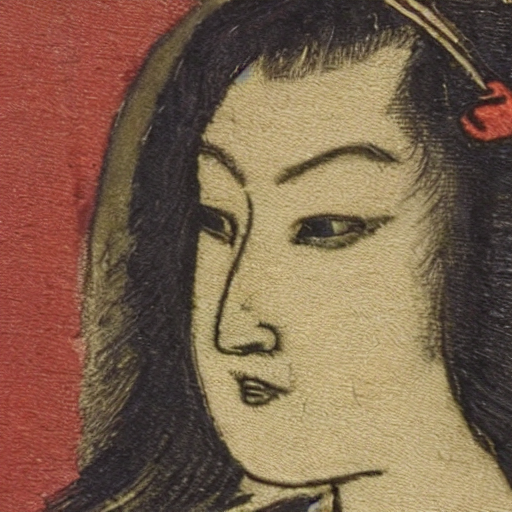

In [16]:
prompt = "Mona Lisa"

output = pipe(
    prompt=prompt,
    generator=torch.manual_seed(hparams.seed),
)
image = output.images[0]
image